In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
rc('animation', html='jshtml')
from scipy.optimize import curve_fit
from scipy.special import erf


from IPython.display import set_matplotlib_formats

#set_matplotlib_formats("png")
plt.rc("xtick", labelsize=16, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=16, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=16) #Font og fontstørrelse
plt.rc("figure",figsize=(5,3),dpi=250) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks
# plt.tick_params(direction="in", top=True, right=True, labelsize=15)


In [9]:
data_z = [  # m
    0.070, 0.570 ,1.060
]

# Ploariseer filter is on

# Wavelenghts are for MID-IR and in 1/cm
energy_of_beam_lambda_3355_1_cm = [  # mW
    [
        33, 34, 34, 30, 30, 30, 32, 30, 29, 24, 20, 18, 17, 14, 10, 7, 5, 4, 1, 0, 0, 0, 0, 0
    ],
    [
        28, 28, 30, 28, 25, 26, 22, 20, 17, 14, 12, 12, 12, 10, 9, 7, 6, 5, 4, 2, 1, 0, 0, 0
    ],
    [
        23, 19, 18, 14, 16, 14, 11, 11, 12, 11, 13, 12, 10, 10, 7, 7, 7, 6, 4, 4, 3, 1, 0, 0 
    ]
]

energy_of_beam_lambda_3864_1_cm = [  # mW
    [
        20, 20, 19, 21, 21, 19, 15, 15, 19, 17, 13, 12, 13, 12, 8, 8, 5, 3, 1, 0, 0, 0 
    ],
    [
        20, 17, 14, 15, 16, 15, 14, 14, 14, 11, 10, 7, 7, 7, 5, 4, 3, 3, 2, 2, 1, 0, 0
    ],
    [
        10, 9, 9, 10, 7, 6, 5, 7, 4, 4, 6, 5, 5, 3, 4, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0
    ]
]

# one round from 0 to 0 is 0.5 mm we will do with this step size 
# Starting from 0 mm on the thorlabs thing
# m from the top of the laser beam
position_of_blade = np.arange(0, 10, 0.5)

In [10]:
def gaussian_energy_with_offset(x, E_total, w, x0):
    return E_total * 0.5 * (1 - erf(np.sqrt(2) * (x - x0) / w))

In [11]:
def energy_uncertainty_calculation(value: float) -> float:
    if 0 <= value < 5:
        return 1.41
    elif 5 <= value < 10:
        return 2.85
    elif 10 <= value < 15:
        return 4.07
    elif 15 <= value < 20:
        return 7.22
    elif 20 <= value < 25:
        return 5.37
    elif 25 <= value < 30:
        return 5.28
    elif 30 <= value:
        return 5.95
    else:
        return 100


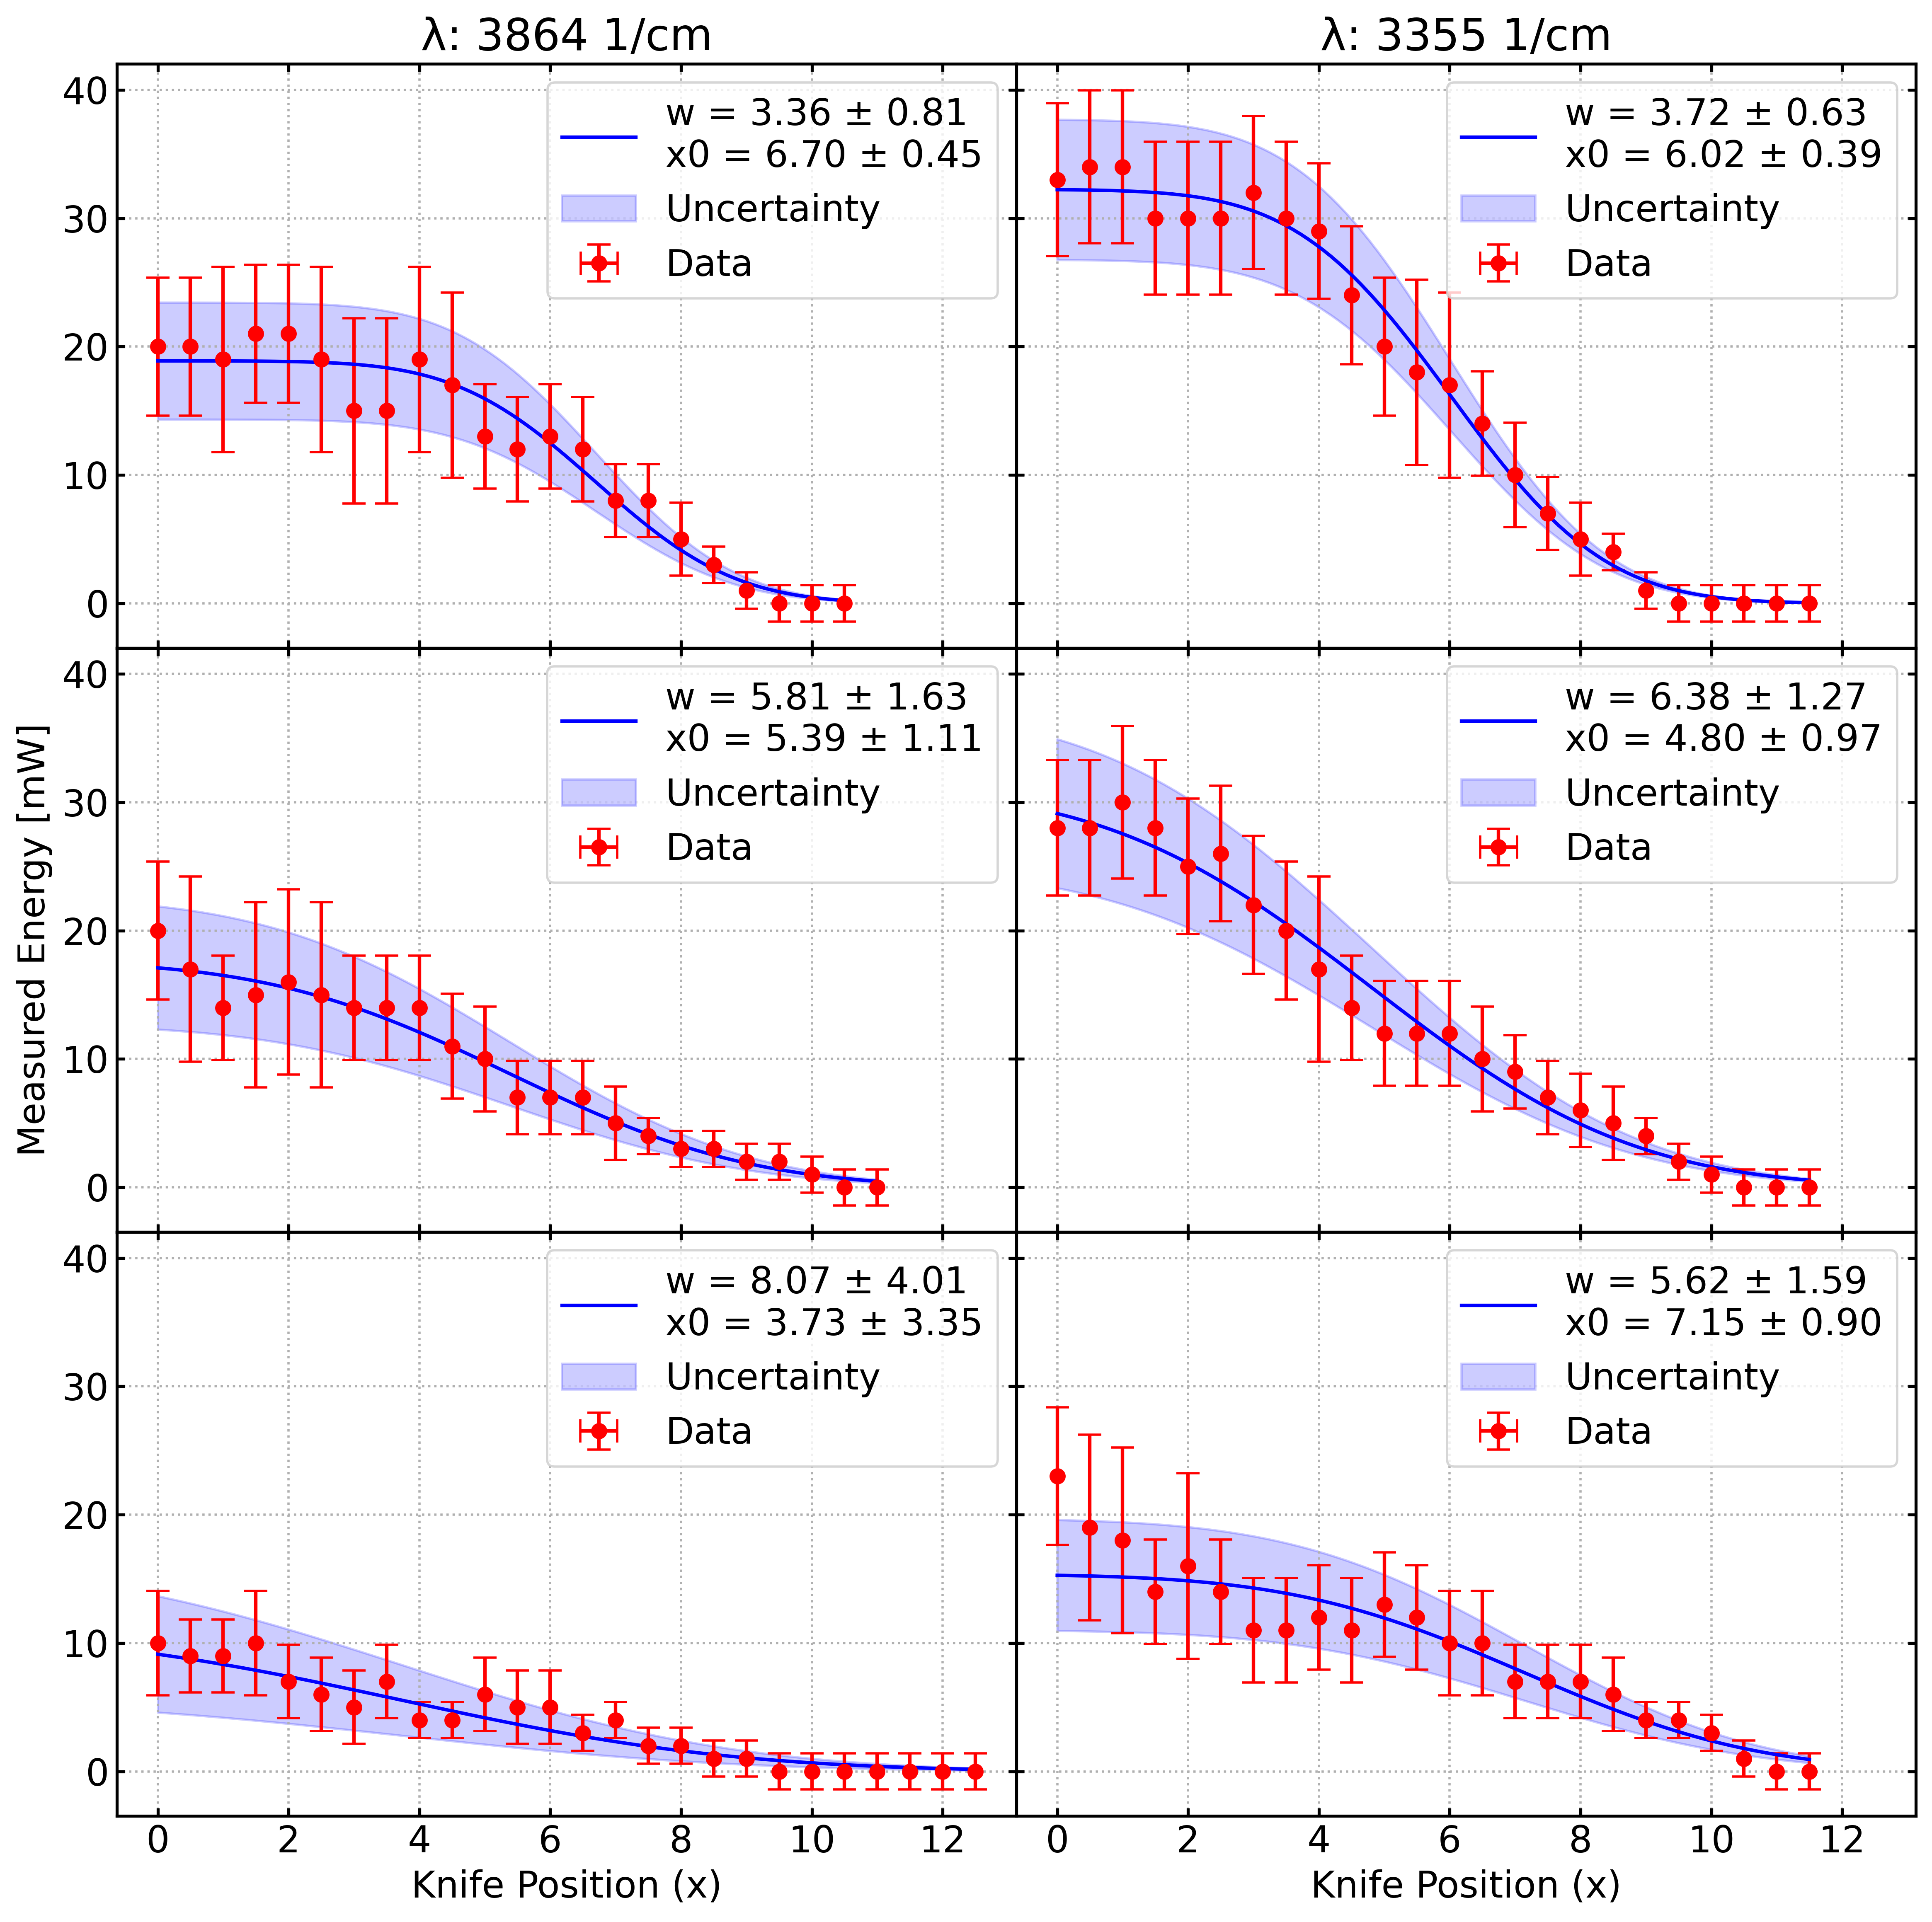

,E,E_err,w,w_err,x0,x0_err,z0,wavenumber 1/cm
0,18.886214,2.149979,3.361845,0.811159,6.699236,0.449250,0.07,3864.0
1,32.241333,2.498562,3.718496,0.630432,6.022219,0.390134,0.07,3355.0
2,17.661485,3.907189,5.808144,1.629883,5.391457,1.106109,0.57,3864.0
3,31.190028,5.392411,6.384023,1.271702,4.800287,0.969504,0.57,3355.0
4,11.096273,6.541323,8.065551,4.006008,3.730533,3.345171,1.06,3864.0
5,15.358756,2.438685,5.615199,1.587551,7.148526,0.895884,1.06,3355.0


In [7]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(14, 14), dpi=400)

df = pd.DataFrame(columns=["E", "E_err", "w", "w_err", "x0", "x0_err", "z0", "wavenumber 1/cm"])

for i in range(3):
    for j in range(2):
    
        ax = axs[i, j]
        z0_temp = data_z[i]
    
        energys = energy_of_beam_lambda_3355_1_cm[i] if j == 1 else energy_of_beam_lambda_3864_1_cm[i]

        # Knife positions mm
        x = np.arange(0, len(energys) / 2, 0.5) 

        # Measured energy at each knife position
        energy = np.array(energys)

        x_uncertainty = np.zeros(len(x)) + 0.001  # Knife position uncertainties (mm)
        energy_uncertainty = np.array([energy_uncertainty_calculation(i) for i in energy])  # Energy uncertainties

        initial_guesses = [max(energy), 4.0, 5.0]  # E_total, w, x0 

        params, covariance = curve_fit(
            gaussian_energy_with_offset, x, energy, p0=initial_guesses,
            sigma=energy_uncertainty, absolute_sigma=True
        )

        E_total_fit, w_fit, x0_fit = params
        perr = np.sqrt(np.diag(covariance))
        E_total_err, w_err, x0_err = perr

        x_fit = np.linspace(min(x), max(x), 100)
        energy_fit = gaussian_energy_with_offset(x_fit, E_total_fit, w_fit, x0_fit)

        # adding all numbers to pd.DataFrame
        wavenumber = 3355 if j == 1 else 3864
        df.loc[i * 2 + j] = [E_total_fit, E_total_err, w_fit, w_err, x0_fit, x0_err, z0_temp, wavenumber]

        ax.errorbar(x, energy, yerr=energy_uncertainty, xerr=x_uncertainty, fmt='o', 
                     label='Data', 
                    color='red', capsize=5)
        ax.plot(x_fit, energy_fit, 
                 label=f'w = {w_fit:.2f} ± {w_err:.2f}\nx0 = {x0_fit:.2f} ± {x0_err:.2f}',
                 color='blue')
        ax.fill_between(x_fit, energy_fit * (1 - w_err / w_fit), energy_fit * (1 + w_err / w_fit), 
                color='blue', alpha=0.2, label="Uncertainty")
        ax.legend()
        # ax.grid(True)

        if i == 0:
            if j == 1:
                ax.set_title(f'λ: 3355 1/cm')
            else:
                ax.set_title(f'λ: 3864 1/cm')

        if i == 1:
            if j == 0:
                ax.set_ylabel('Measured Energy [mW]')
                
       # if i == 2:
        ax.set_xlabel('Knife Position (x)')
            
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
df

In [12]:
def linear_func(x, a, b):
    return x * a + b

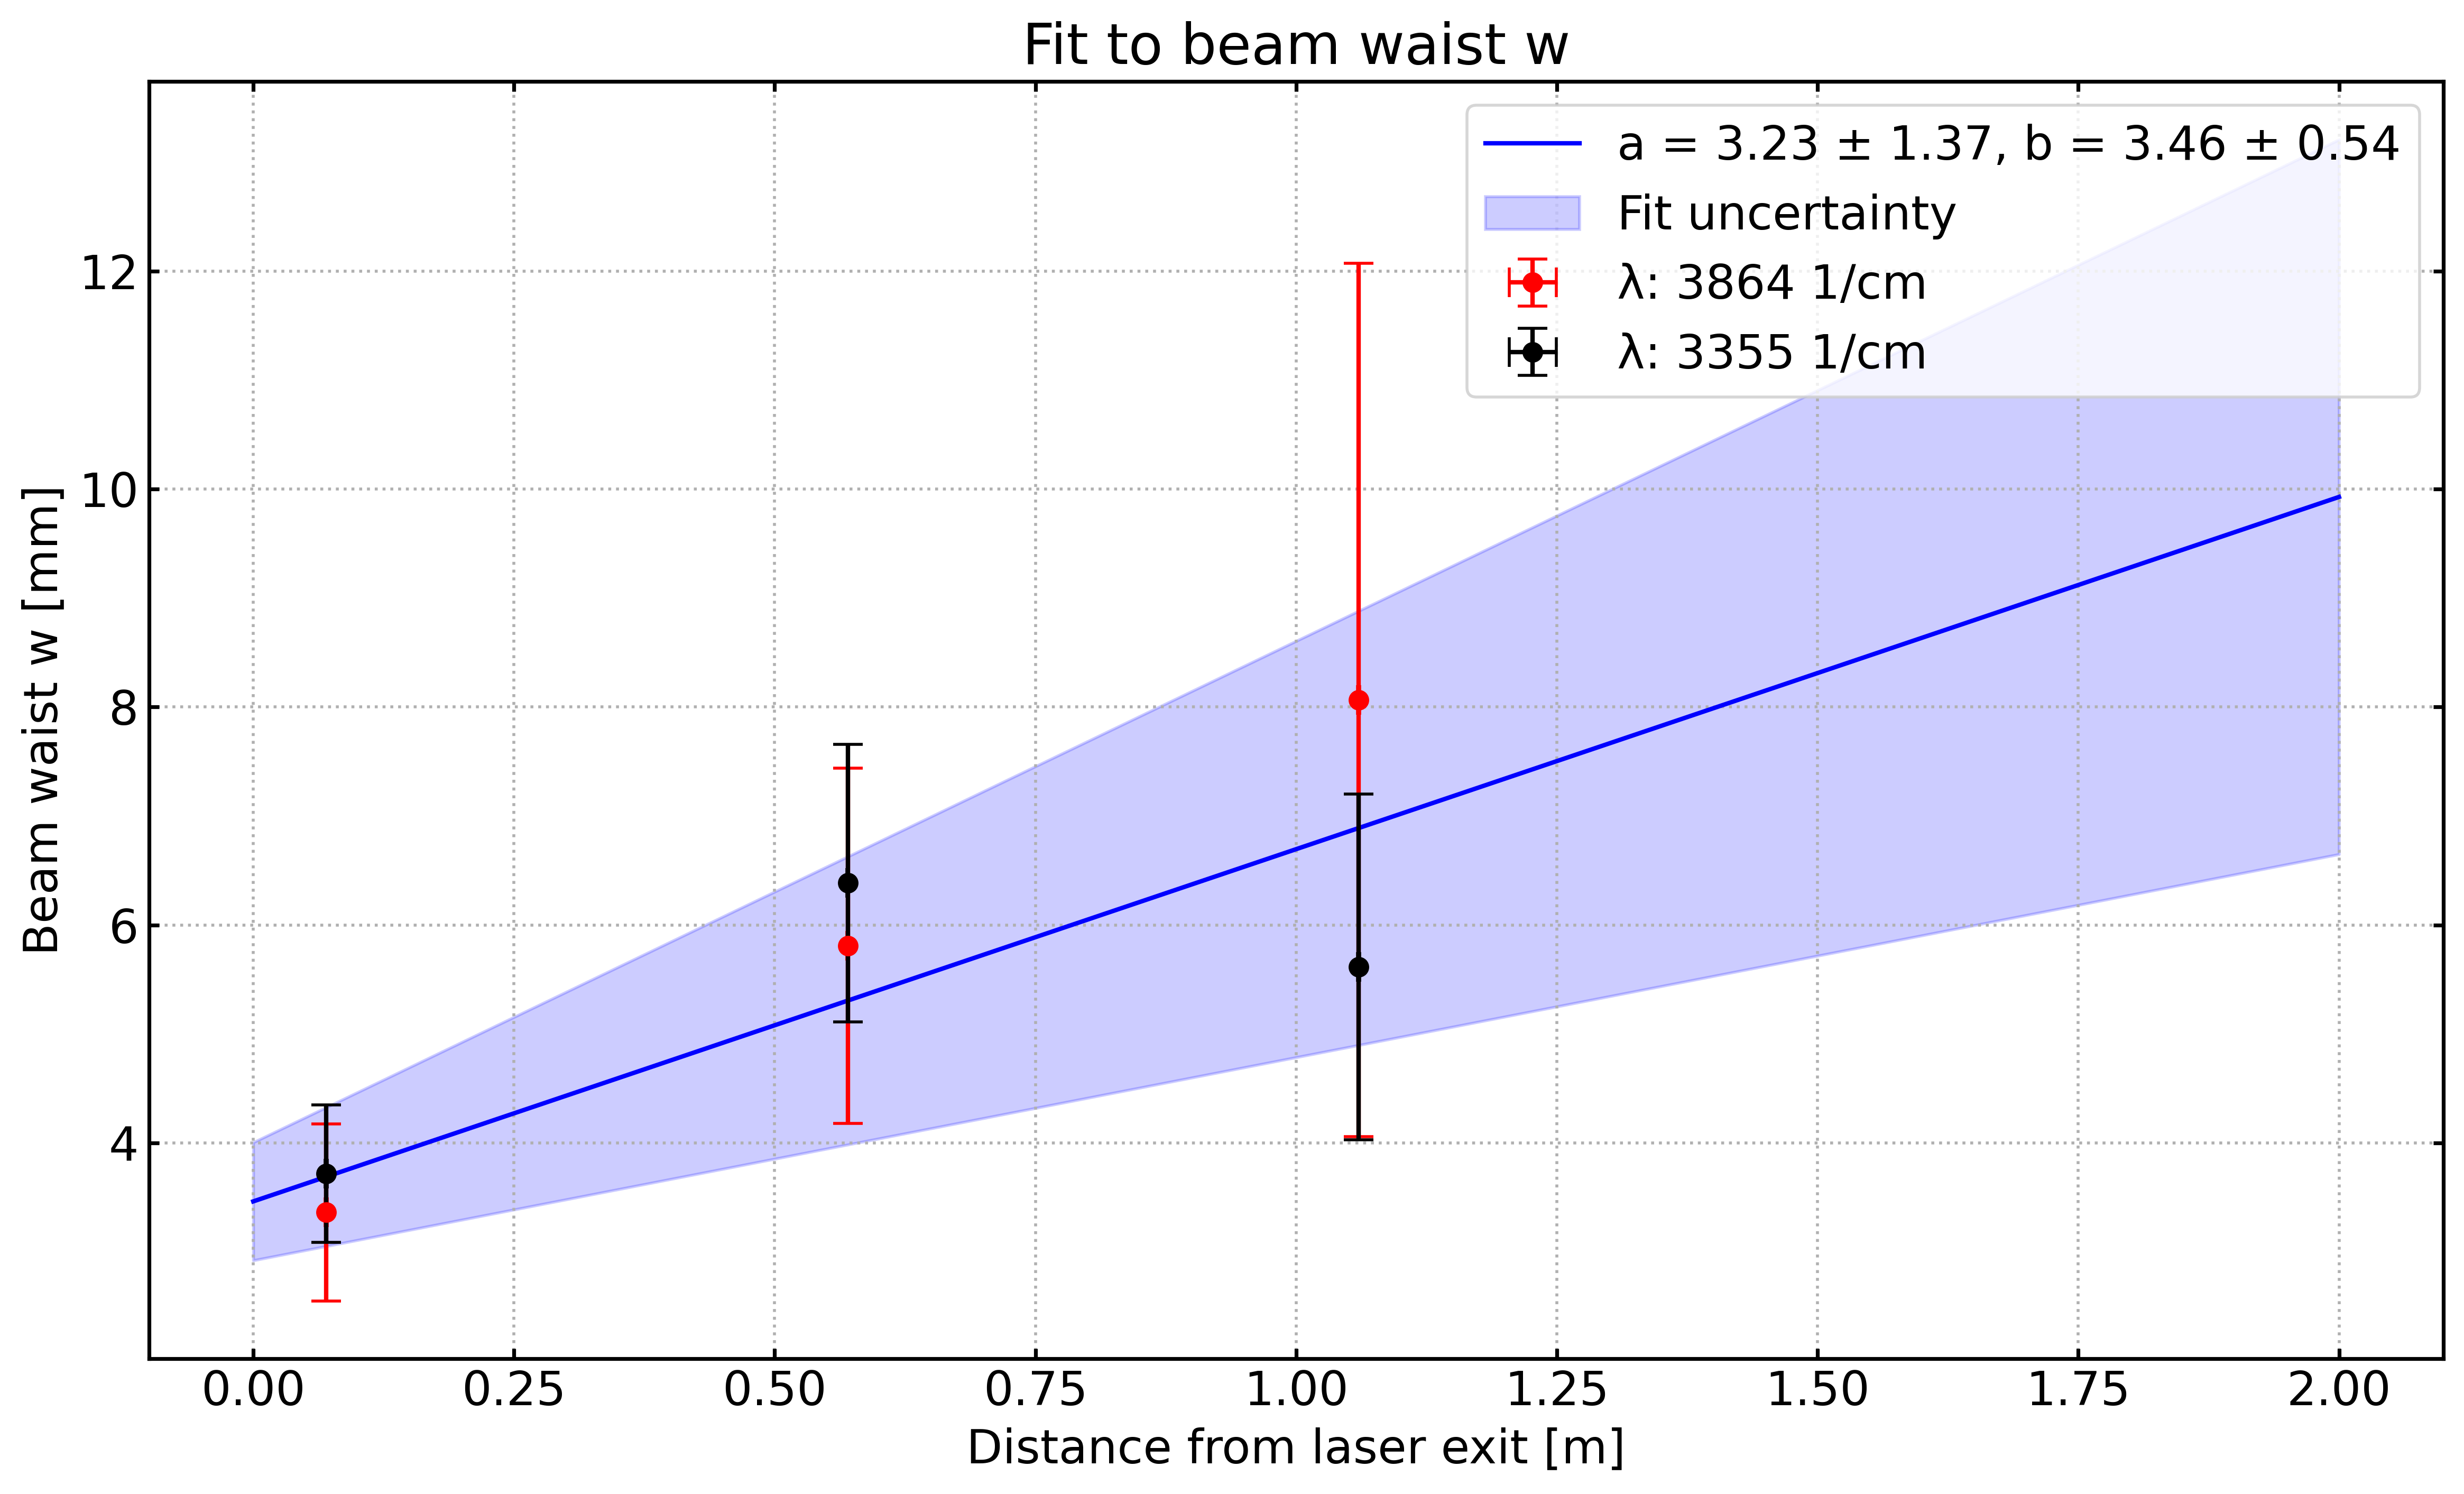

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(14, 8), dpi=400)


#initial_guesses = [4.0, 5.0]  # a, bvv 


popt, pcov = curve_fit(linear_func, df["z0"], df["w"], sigma=df["w_err"], absolute_sigma=True)
a_fit, b_fit = popt 
a_err, b_err = np.sqrt(np.diag(pcov)) 

# Generate the fitted curve
x_fit = np.linspace(0, 2, 1000)  # High-resolution x for the fit line
y_fit = linear_func(x_fit, a_fit, b_fit)

ax.plot(x_fit, y_fit, 
        label=f'a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}', 
        color='blue')

y_fit_upper = linear_func(x_fit, a_fit + a_err, b_fit + b_err)
y_fit_lower = linear_func(x_fit, a_fit - a_err, b_fit - b_err)
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='blue', alpha=0.2, label='Fit uncertainty')


ax.errorbar(df.loc[df["wavenumber 1/cm"] == 3864, "z0"], 
            df.loc[df["wavenumber 1/cm"] == 3864, "w"], 
            yerr=df.loc[df["wavenumber 1/cm"] == 3864, "w_err"], xerr=0.001, fmt='o', 
            label='λ: 3864 1/cm', 
            color='red', capsize=5)

ax.errorbar(df.loc[df["wavenumber 1/cm"] == 3355, "z0"], 
            df.loc[df["wavenumber 1/cm"] == 3355, "w"], 
            yerr=df.loc[df["wavenumber 1/cm"] == 3355, "w_err"], xerr=0.001, fmt='o', 
            label='λ: 3355 1/cm', 
            color='black', capsize=5)

ax.set_ylabel("Beam waist w [mm]")
ax.set_xlabel("Distance from laser exit [m]")

ax.legend()
plt.title("Fit to beam waist w")
plt.show()


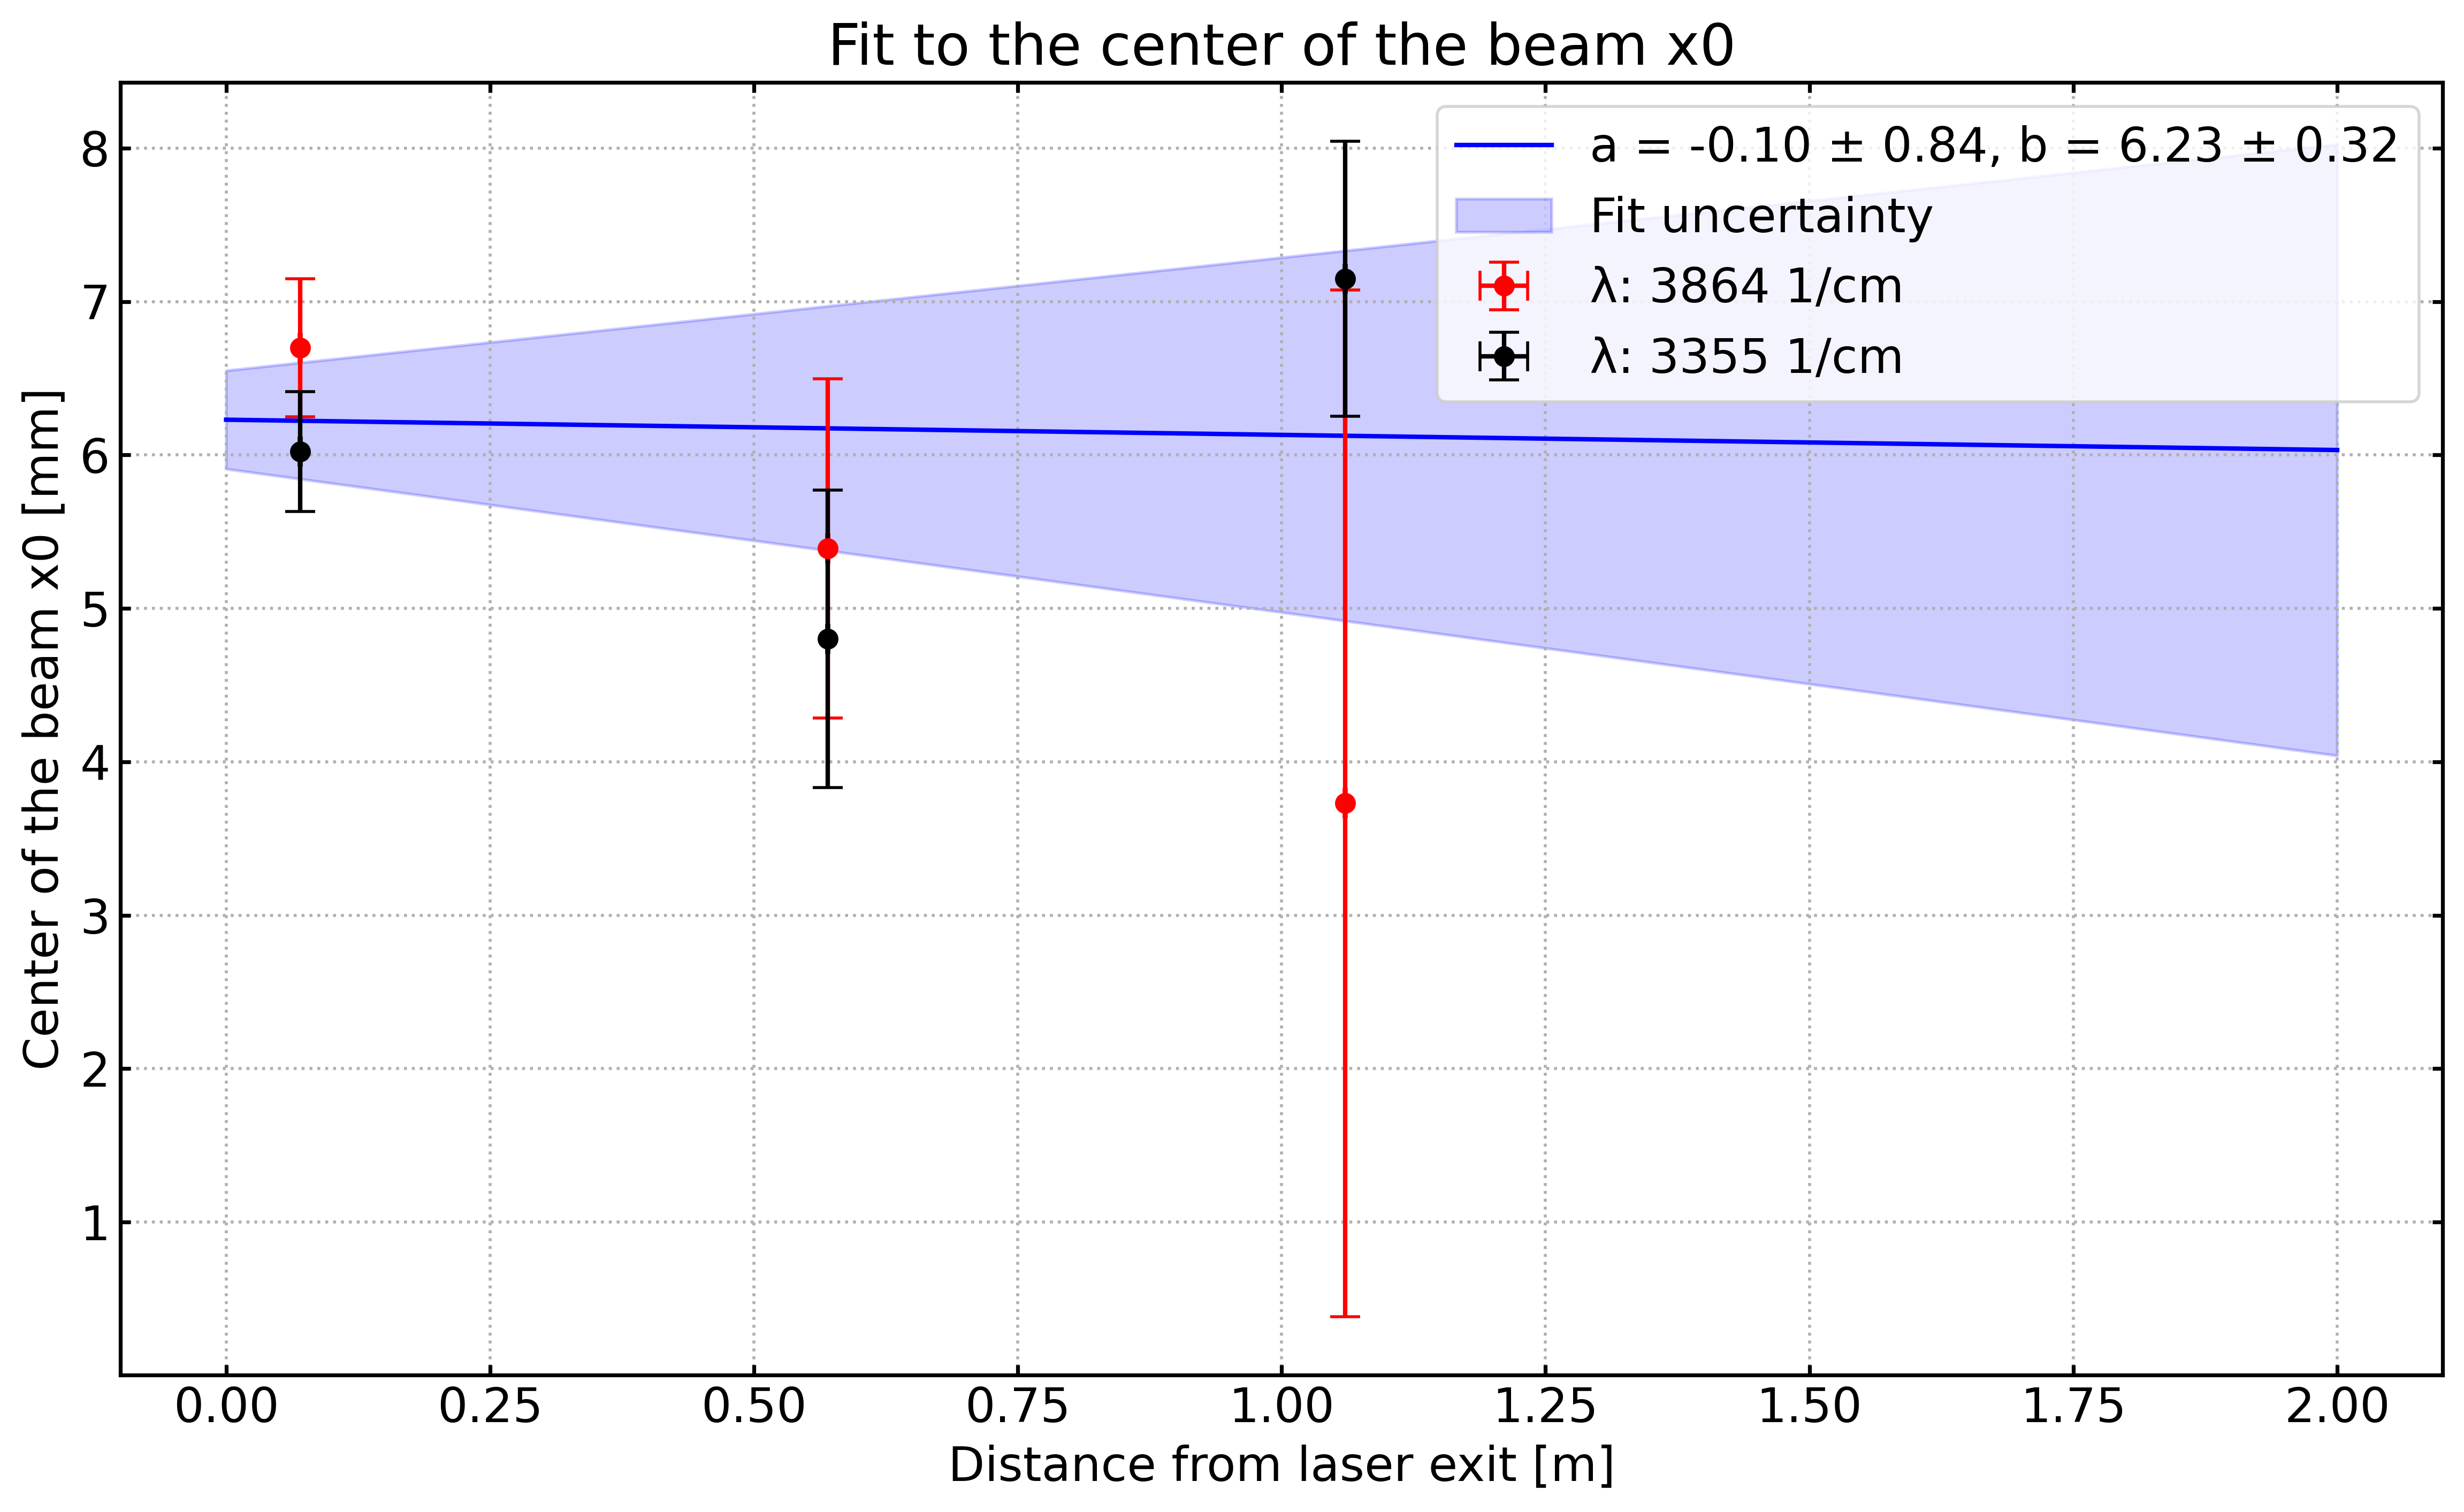

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(14, 8), dpi=400)

popt, pcov = curve_fit(linear_func, df["z0"], df["x0"], sigma=df["x0_err"], absolute_sigma=True)
a_fit, b_fit = popt 
a_err, b_err = np.sqrt(np.diag(pcov)) 

x_fit = np.linspace(0, 2, 1000) 
y_fit = linear_func(x_fit, a_fit, b_fit)

ax.plot(x_fit, y_fit, 
        label=f'a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}', 
        color='blue')

y_fit_upper = linear_func(x_fit, a_fit + a_err, b_fit + b_err)
y_fit_lower = linear_func(x_fit, a_fit - a_err, b_fit - b_err)
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='blue', alpha=0.2, label='Fit uncertainty')


ax.errorbar(df.loc[df["wavenumber 1/cm"] == 3864, "z0"], 
            df.loc[df["wavenumber 1/cm"] == 3864, "x0"], 
            yerr=df.loc[df["wavenumber 1/cm"] == 3864, "x0_err"], xerr=0.001, fmt='o', 
            label='λ: 3864 1/cm', 
            color='red', capsize=5)

ax.errorbar(df.loc[df["wavenumber 1/cm"] == 3355, "z0"], 
            df.loc[df["wavenumber 1/cm"] == 3355, "x0"], 
            yerr=df.loc[df["wavenumber 1/cm"] == 3355, "x0_err"], xerr=0.001, fmt='o', 
            label='λ: 3355 1/cm', 
            color='black', capsize=5)

ax.set_ylabel("Center of the beam x0 [mm]")
ax.set_xlabel("Distance from laser exit [m]")

ax.legend()
plt.title("Fit to the center of the beam x0")
plt.show()


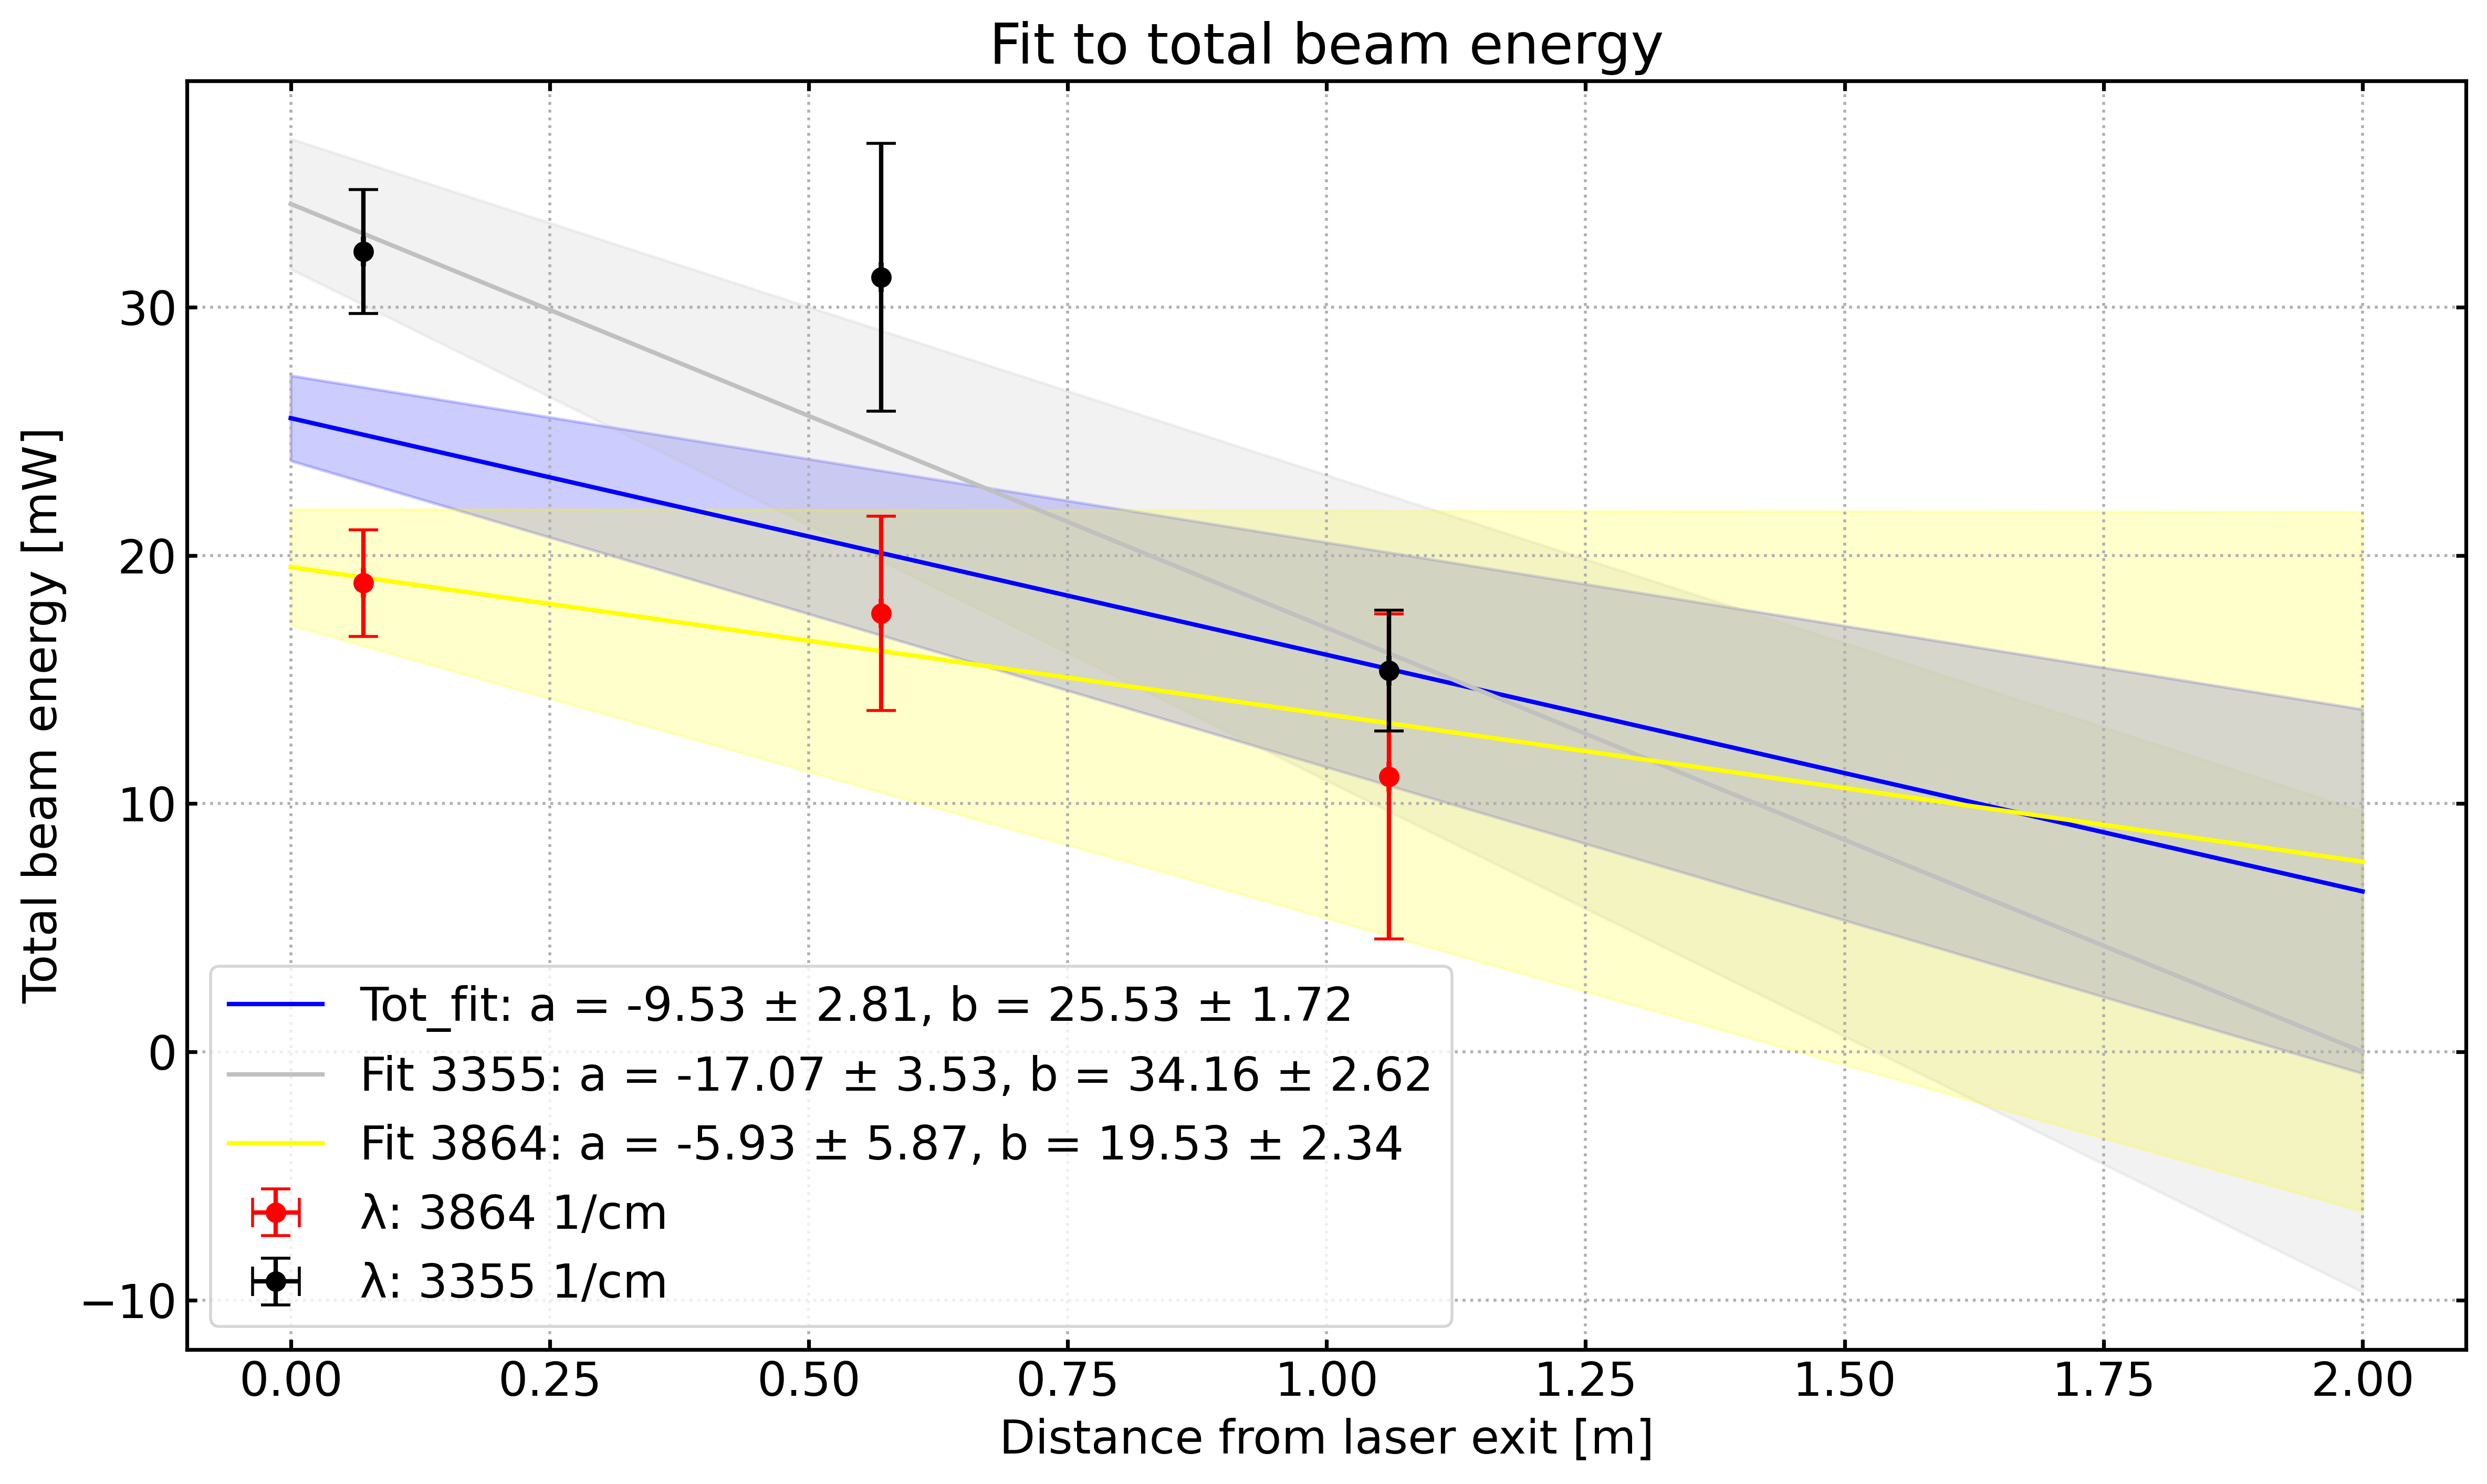

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(14, 8), dpi=400)

e1 = df.loc[df["wavenumber 1/cm"] == 3355, "E"]
e1_err = df.loc[df["wavenumber 1/cm"] == 3355, "E_err"]

e2 = df.loc[df["wavenumber 1/cm"] == 3864, "E"]
e2_err = df.loc[df["wavenumber 1/cm"] == 3864, "E_err"]

popt, pcov = curve_fit(linear_func, df["z0"], df["E"], sigma=df["E_err"], absolute_sigma=True)
a_fit, b_fit = popt 
a_err, b_err = np.sqrt(np.diag(pcov)) 

x_fit = np.linspace(0, 2, 1000)
y_fit = linear_func(x_fit, a_fit, b_fit)

ax.plot(x_fit, y_fit, 
        label=f'Tot_fit: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}', 
        color='Blue')

y_fit_upper = linear_func(x_fit, a_fit + a_err, b_fit + b_err)
y_fit_lower = linear_func(x_fit, a_fit - a_err, b_fit - b_err)
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='Blue', alpha=0.2)#, label='Fit uncertainty')

popt, pcov = curve_fit(linear_func, data_z, e1, sigma=e1_err, absolute_sigma=True)
a_fit, b_fit = popt 
a_err, b_err = np.sqrt(np.diag(pcov)) 

x_fit = np.linspace(0, 2, 1000)
y_fit = linear_func(x_fit, a_fit, b_fit)

ax.plot(x_fit, y_fit, 
        label=f'Fit 3355: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}', 
        color='silver')

y_fit_upper = linear_func(x_fit, a_fit + a_err, b_fit + b_err)
y_fit_lower = linear_func(x_fit, a_fit - a_err, b_fit - b_err)
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='silver', alpha=0.2)# , label='Fit uncertainty')

popt, pcov = curve_fit(linear_func, data_z, e2, sigma=e2_err, absolute_sigma=True)
a_fit, b_fit = popt 
a_err, b_err = np.sqrt(np.diag(pcov)) 

x_fit = np.linspace(0, 2, 1000) 
y_fit = linear_func(x_fit, a_fit, b_fit)

ax.plot(x_fit, y_fit, 
        label=f'Fit 3864: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}', 
        color='yellow')

y_fit_upper = linear_func(x_fit, a_fit + a_err, b_fit + b_err)
y_fit_lower = linear_func(x_fit, a_fit - a_err, b_fit - b_err)
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='yellow', alpha=0.2) #, label='Fit uncertainty')


ax.errorbar(df.loc[df["wavenumber 1/cm"] == 3864, "z0"], 
            df.loc[df["wavenumber 1/cm"] == 3864, "E"], 
            yerr=df.loc[df["wavenumber 1/cm"] == 3864, "E_err"], xerr=0.001, fmt='o', 
            label='λ: 3864 1/cm', 
            color='red', capsize=5)

ax.errorbar(df.loc[df["wavenumber 1/cm"] == 3355, "z0"], 
            df.loc[df["wavenumber 1/cm"] == 3355, "E"], 
            yerr=df.loc[df["wavenumber 1/cm"] == 3355, "E_err"], xerr=0.001, fmt='o', 
            label='λ: 3355 1/cm', 
            color='black', capsize=5)

ax.set_ylabel("Total beam energy [mW]")
ax.set_xlabel("Distance from laser exit [m]")

ax.legend()
plt.title("Fit to total beam energy")
plt.show()
